# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading Fruits360 Dataset

In [ ]:
import matplotlib.image as mpimg
import cv2
import os

### Loading files (Run Seperately if it fails)

In [ ]:
import time

!gdown https://raw.githubusercontent.com/Soumik-Roy/PRML-Datasets/main/kaggle.json
time.sleep(3) 

Downloading...
From: https://raw.githubusercontent.com/Soumik-Roy/PRML-Datasets/main/kaggle.json
To: /content/kaggle.json
 78% 67.0/86.0 [00:00<00:00, 126kB/s]


In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!rm /content/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:07<00:00, 200MB/s]
100% 1.28G/1.28G [00:07<00:00, 189MB/s]


In [ ]:
![[ ! -d /content/fruits360 ]] && unzip fruits.zip -d /content/fruits360/ &> /dev/null

In [ ]:
!rm -r fruits360/fruits-360-original-size/
!rm fruits.zip

### Creating Dataset

In [ ]:
path = "/content/fruits360/fruits-360_dataset/fruits-360/"
train_path = path + "Training/"
test_path = path + "Test/"

train_fruits = list(os.listdir(train_path)) # sort for alphabetical order
test_fruits = list(os.listdir(test_path)) # sort for alphabetical order

train_fruits.sort()
test_fruits.sort()

In [ ]:
len(test_fruits), len(train_fruits)

(131, 131)

In [ ]:
fruit_labels = {i:train_fruits[i] for i in range(len(train_fruits))}

In [ ]:
img = mpimg.imread(test_path + test_fruits[0]+"/3_100.jpg").flatten().astype(np.int16)
img

array([255, 255, 255, ..., 255, 255, 255], dtype=int16)

In [ ]:
len(img)

30000

#### Creating the dataset from images

In [ ]:
train_data = np.array([], dtype=np.int8)
test_data = np.array([], dtype=np.int8)

im_shape = (20,20) ## Image shape after resizing 

for i in tqdm(range(len(train_fruits))): 
  img_paths_tr = list(os.listdir(train_path + train_fruits[i]))
  img_paths_tst = list(os.listdir(test_path + test_fruits[i]))

  # Training data
  imgs = [] 
  for p in img_paths_tr:
    img = mpimg.imread(train_path + train_fruits[i] + '/' + p)
    img = cv2.resize(img,  im_shape, interpolation = cv2.INTER_AREA).flatten()
    imgs.append(img)
  imgs = np.array(imgs).astype(np.int16)
  imgs = np.concatenate((imgs, np.ones((imgs.shape[0], 1))*i), axis=1)
  train_data = np.concatenate((train_data.reshape(train_data.shape[0],imgs.shape[1]), imgs), axis = 0).astype(np.int16)


  # Testing data
  imgs = [] 
  for p in img_paths_tst:
    img = mpimg.imread(test_path + test_fruits[i] + '/' + p)
    img = cv2.resize(img,  im_shape, interpolation = cv2.INTER_AREA).flatten()
    imgs.append(img)
  imgs = np.array(imgs).astype(np.int16)
  imgs = np.concatenate((imgs, np.ones((imgs.shape[0], 1))*i), axis=1)
  test_data = np.concatenate((test_data.reshape(test_data.shape[0],imgs.shape[1]), imgs), axis = 0).astype(np.int16)

100%|██████████| 131/131 [01:02<00:00,  2.09it/s]


In [ ]:
col_names = ['pixel'+str(i+1) for i in range(train_data.shape[1]-1)] + ['labels']

train_data = pd.DataFrame(train_data, columns = col_names)
test_data = pd.DataFrame(test_data, columns = col_names)

train_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel1192,pixel1193,pixel1194,pixel1195,pixel1196,pixel1197,pixel1198,pixel1199,pixel1200,labels
0,253,254,253,253,255,254,254,254,254,253,...,255,255,255,255,255,255,255,255,255,0
1,255,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,255,0
2,253,254,254,252,254,254,253,254,254,251,...,254,255,254,254,255,255,255,255,255,0
3,254,254,255,253,254,254,254,254,253,253,...,254,255,255,255,255,255,255,255,255,0
4,254,254,253,253,255,252,255,254,254,252,...,254,255,255,255,255,255,255,255,255,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67692 entries, 0 to 67691
Columns: 1201 entries, pixel1 to labels
dtypes: int16(1201)
memory usage: 155.1 MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22688 entries, 0 to 22687
Columns: 1201 entries, pixel1 to labels
dtypes: int16(1201)
memory usage: 52.0 MB


#### Train, validation and test Data

In [ ]:
X = train_data.values[:, :-1]
Y = train_data.values[:, -1]

In [ ]:
test_X = test_data.values[:, :-1]
test_Y = test_data.values[:, -1]

# Dimension Reduction

## LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
X_lda = lda.fit_transform(X, Y)
X_lda.shape

(67692, 130)

In [ ]:
test_X_lda = lda.transform(test_X)
test_X_lda.shape

(22688, 130)

In [ ]:
from sklearn.model_selection import train_test_split as tts

X_train, X_val, Y_train, Y_val, X_train_lda, X_val_lda = tts(X, Y, X_lda, test_size=0.3, random_state=20, stratify = Y)

#### Creating Subset containing only 10% data

In [ ]:
X_train_10p = X_train[:int(0.1*X_train.shape[0]), :]
X_val_10p = X_val[:int(0.1*X_val.shape[0]), :]
Y_train_10p = Y_train[:int(0.1*X_train.shape[0])]
Y_val_10p = Y_val[:int(0.1*X_val.shape[0])]
X_train_lda_10p = X_train_lda[:int(0.1*X_train_lda.shape[0]), :]
X_val_lda_10p = X_val_lda[:int(0.1*X_val_lda.shape[0]), :]

In [ ]:
X_train_10p.shape, X_val_10p.shape

((4738, 1200), (2030, 1200))

In [ ]:
Y_train_10p.shape

(4738,)

In [ ]:
len(np.unique(Y_train_10p))

131

In [ ]:
len(np.unique(Y_val_10p))

131

#### Explained Variance

In [ ]:
lda.explained_variance_ratio_

array([0.24694759, 0.13051312, 0.06409842, 0.05908067, 0.04069433,
       0.02238348, 0.02027802, 0.01797034, 0.01634483, 0.01480964,
       0.01395945, 0.01268561, 0.01130473, 0.01047705, 0.00999835,
       0.00939948, 0.00887038, 0.0086159 , 0.00840416, 0.00815252,
       0.00766065, 0.00718549, 0.00698125, 0.00679113, 0.00646361,
       0.00602192, 0.005935  , 0.00585091, 0.00573266, 0.00542374,
       0.00533259, 0.00523843, 0.00498189, 0.00484668, 0.00463722,
       0.00459353, 0.00455175, 0.00448984, 0.00434478, 0.00408985,
       0.00401003, 0.00395495, 0.00379509, 0.00374519, 0.00363767,
       0.00351737, 0.00347607, 0.00337225, 0.0033011 , 0.00323891,
       0.00318324, 0.00311148, 0.00301187, 0.00296096, 0.00288058,
       0.00284451, 0.00280268, 0.00273894, 0.00270068, 0.00261596,
       0.00256687, 0.00254524, 0.00247584, 0.00243497, 0.00236382,
       0.00228425, 0.00222465, 0.00217208, 0.00209918, 0.00206134,
       0.00201687, 0.00195298, 0.00194066, 0.00190149, 0.00185

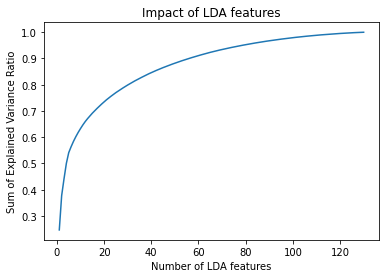

In [ ]:
explained_var_sums = [sum(lda.explained_variance_ratio_[:i+1]) for i in range(len(lda.explained_variance_ratio_))]

plt.plot(range(1, len(lda.explained_variance_ratio_)+1), explained_var_sums)
plt.xlabel('Number of LDA features')
plt.ylabel('Sum of Explained Variance Ratio')
plt.title('Impact of LDA features')
plt.show()

#### Visualisation

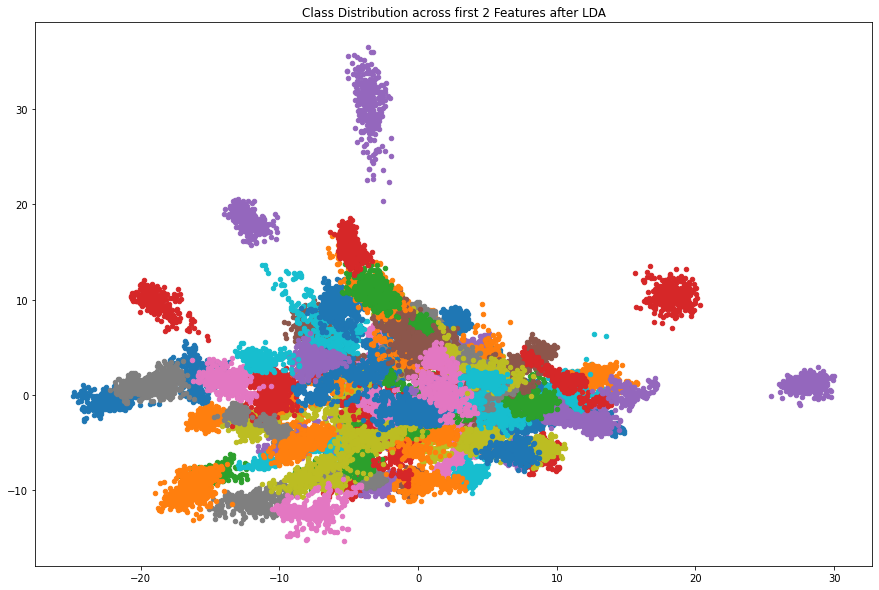

In [ ]:
X_train_lda_2 = X_train_lda[:,:2]
df = pd.DataFrame(X_train_lda_2, columns = [str(i) for i in range(X_train_lda_2.shape[1])])
df['y'] = Y_train
plt.figure(figsize = (15,10))
for cls in np.unique(Y_train):
  plt.scatter(df.loc[df['y']==cls, '0'], df.loc[df['y']==cls, '1'], s = 20)
plt.title('Class Distribution across first 2 Features after LDA')
plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X, Y)
X_pca.shape

(67692, 1200)

In [ ]:
test_X_pca = pca.transform(test_X)
test_X_pca.shape

(22688, 1200)

In [ ]:
from sklearn.model_selection import train_test_split as tts

X_train_pca, X_val_pca = tts(X_pca, test_size=0.3, random_state=20, stratify = Y)

#### Creating Subset containing only 10% data

In [ ]:
X_train_pca_10p = X_train_pca[:int(0.1*X_train_pca.shape[0]), :]
X_val_pca_10p = X_val_pca[:int(0.1*X_val_pca.shape[0]), :]

#### Explained Variance

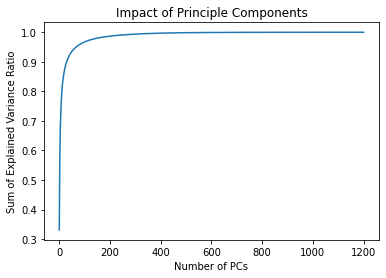

In [ ]:
explained_var_sums = [sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), explained_var_sums)
plt.xlabel('Number of PCs')
plt.ylabel('Sum of Explained Variance Ratio')
plt.title('Impact of Principle Components')
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([3.31159046e-01, 1.34892603e-01, 1.13010811e-01, ...,
       2.68931778e-09, 3.20477072e-10, 7.36114704e-11])

Taking just 30 PCs will account for 90% of the explained variance being covered

In [ ]:
explained_var_sums[30]

0.9026945542327186

#### Visualisation

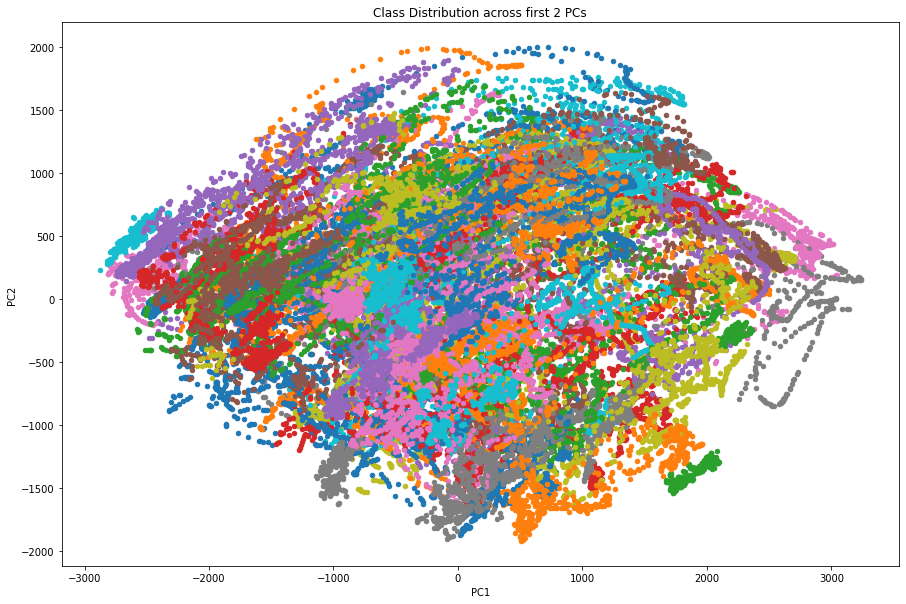

In [ ]:
X_train_pca_2 = X_train_pca[:,:2]
df = pd.DataFrame(X_train_pca_2, columns = [str(i) for i in range(X_train_pca_2.shape[1])])
df['y'] = Y_train
plt.figure(figsize = (15,10))
for cls in np.unique(Y_train):
  plt.scatter(df.loc[df['y']==cls, '0'], df.loc[df['y']==cls, '1'], s = 20)
plt.title('Class Distribution across first 2 PCs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# MODELS

## K-Nearest Neighbours (KNN)

#### Original Data

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as KNN 

knn1 = KNN()
knn1.fit(X_train, Y_train)

y_pred_val_knn1 = knn1.predict(X_val)
acc_val_knn1 = accuracy_score(Y_val, y_pred_val_knn1)
print("Accuracy on the Validation Dataset", acc_val_knn1)

Accuracy on the Validation Dataset 0.9978333661611187


#### With LDA

In [ ]:
knn2 = KNN()
knn2.fit(X_train_lda, Y_train)

y_pred_val_knn2 = knn2.predict(X_val_lda)
acc_val_knn2 = accuracy_score(Y_val, y_pred_val_knn2)
print("Accuracy on the Validation Dataset", acc_val_knn2)

Accuracy on the Validation Dataset 0.9979318495174315


#### With PCA

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as KNN 

knn3 = KNN()
knn3.fit(X_train_pca[:, :30], Y_train)

y_pred_val_knn3 = knn3.predict(X_val_pca[:, :30])
acc_val_knn3 = accuracy_score(Y_val, y_pred_val_knn3)
print("Accuracy on the Validation Dataset", acc_val_knn3)

Accuracy on the Validation Dataset 0.9972424660232421


#### Optimising n_neighbours

In [ ]:
best_acc_knn1 = 0
best_acc_knn2 = 0
best_acc_knn3 = 0

best_nn1 = 1
best_nn2 = 1
best_nn3 = 1

accs_knn1 = []
accs_knn2 = []
accs_knn3 = []

for nn in tqdm(range(3, 10)):
  knn = KNN(n_neighbors=nn)
  knn.fit(X_train_10p, Y_train_10p) 
  ypr = knn.predict(X_val_10p)
  ac = accuracy_score(Y_val_10p, ypr)
  accs_knn1.append(ac)
  if(ac>best_acc_knn1):
    best_acc_knn1 = ac
    best_nn1 = nn

  knn.fit(X_train_lda_10p, Y_train_10p)
  ypr = knn.predict(X_val_lda_10p)
  ac = accuracy_score(Y_val_10p, ypr)
  accs_knn2.append(ac)
  if(ac>best_acc_knn2):
    best_acc_knn2 = ac
    best_nn2 = nn

  knn.fit(X_train_pca_10p[:, :30], Y_train_10p)
  ypr = knn.predict(X_val_pca_10p[:, :30])
  ac = accuracy_score(Y_val_10p, ypr)
  accs_knn3.append(ac)
  if(ac>best_acc_knn3):
    best_acc_knn3 = ac
    best_nn3 = nn

100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


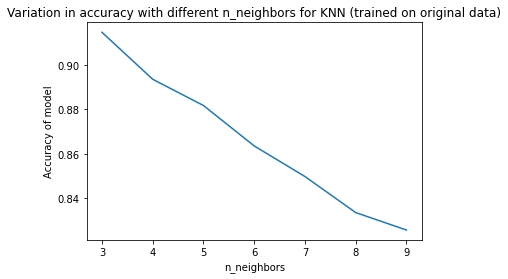

In [ ]:
plt.plot(range(3,10), accs_knn1) 
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy of model')
plt.title("Variation in accuracy with different n_neighbors for KNN (trained on original data)")
plt.show() 

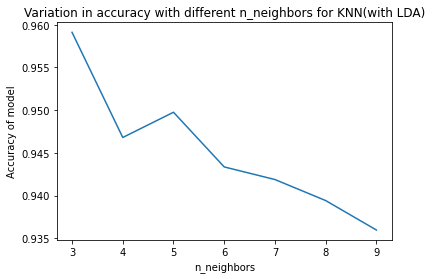

In [ ]:
plt.plot(range(3,10), accs_knn2)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy of model')
plt.title("Variation in accuracy with different n_neighbors for KNN(with LDA)")
plt.show()

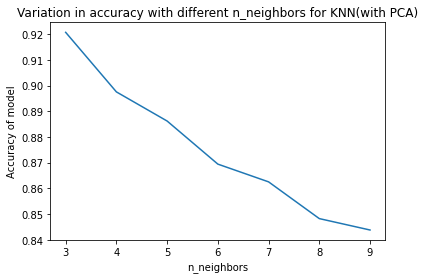

In [ ]:
plt.plot(range(3,10), accs_knn3)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy of model')
plt.title("Variation in accuracy with different n_neighbors for KNN(with PCA)")
plt.show()

#### Performance on Testing Data

In [ ]:
y_pred_test = knn1.predict(test_X)
acc_test = accuracy_score(test_Y, y_pred_test)
print("Accuracy on the Testing Dataset (Original) : ", acc_test)

y_pred_test = knn2.predict(test_X_lda)
acc_test = accuracy_score(test_Y, y_pred_test)
print("Accuracy on the Testing Dataset (with LDA) : ", acc_test)

y_pred_test = knn3.predict(test_X_pca[:, :30])
acc_test = accuracy_score(test_Y, y_pred_test)
print("Accuracy on the Testing Dataset (with PCA) : ", acc_test)

Accuracy on the Testing Dataset (Original) :  0.8918811706629055
Accuracy on the Testing Dataset (with LDA) :  0.901533850493653
Accuracy on the Testing Dataset (with PCA) :  0.8907792665726375


As we can see, the LDA applied model works best on testing data

In [ ]:
knn = KNN(n_neighbors=best_nn2)
knn.fit(X_lda, Y) 

y_pred_test = knn.predict(test_X_lda)
acc_test = accuracy_score(test_Y, y_pred_test)
print("Final Accuracy on the Testing Dataset : ", acc_test)

Final Accuracy on the Testing Dataset :  0.9192524682651622


#### Visualising random predictions

From given Testing data

Actual fruit : Mango 
Predicted Fruit : Mango


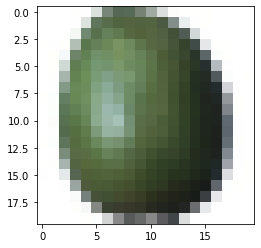

In [ ]:
indx = np.random.randint(0, test_X.shape[0])
pred = y_pred_test[indx] 
actual = test_Y[indx]
img_dim = int((test_X.shape[1]/3)**0.5) 
image = test_X[indx].reshape(img_dim, img_dim,3)
print("Actual fruit : {} \nPredicted Fruit : {}".format(fruit_labels[pred], fruit_labels[actual]))
plt.imshow(image)
plt.show()

Random Image from Google Images

In [ ]:
def predict_random_image(img_path, model, doPCA = False, doLDA=False, isCNN=False):
  img1 = mpimg.imread(img_path)
  img1 = cv2.resize(img1,  im_shape, interpolation = cv2.INTER_AREA).flatten().reshape(1,np.product(im_shape)*3).astype(np.int16)
  print("Original Image")

  plt.imshow(np.resize(img1,(im_shape[0],im_shape[1],3)))
  plt.show()

  if(doPCA):
    img1_pca = pca.transform(img1)
    pred_img = model.predict(img1_pca[:, :30])
  elif(doLDA):
    img1_lda = lda.transform(img1)
    pred_img = model.predict(img1_lda)
  elif(isCNN):
    img1_norm = img1/255.0
    img1_norm = img1_norm.reshape(-3, im_shape[0], im_shape[1], 3)
    pred_img = model.predict(img1_norm).argmax(axis=1)

  else:
    pred_img = model.predict(img1)
  
  print("\nPrediction for the Image : ", fruit_labels[pred_img[0]])
  
  # return fruit_labels[pred_img[0]]

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1Zb2jUK_yJrgV4V6q63vhjF57xAKlM0yV&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1Zb2jUK_yJrgV4V6q63vhjF57xAKlM0yV
To: /content/apple.jpg
100% 48.0k/48.0k [00:00<00:00, 29.4MB/s]


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1g2sI_8QAJbGS3gBfz2kk6G90FovIX6hD&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1g2sI_8QAJbGS3gBfz2kk6G90FovIX6hD
To: /content/banana.jpg
100% 2.09M/2.09M [00:00<00:00, 131MB/s]


Original Image


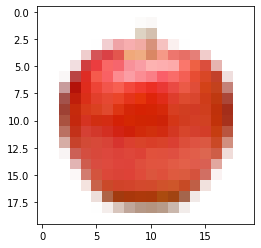


Prediction for the Image :  Cherry Rainier


In [ ]:
predict_random_image("apple.jpg", knn, doLDA=True)

Original Image


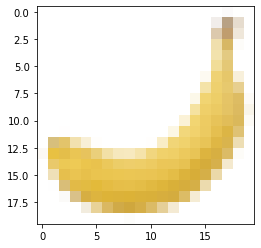


Prediction for the Image :  Pepino


In [ ]:
predict_random_image("banana.jpg", knn, doLDA=True)

## Ensemble Learning

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### Original Data

In [ ]:
rfc1 = RandomForestClassifier(verbose=3, n_jobs=-1)
rfc1.fit(X_train, Y_train) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   31.2s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(n_jobs=-1, verbose=3)

In [ ]:
y_pred_rfc1 = rfc1.predict(X_val)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


In [ ]:
from sklearn.metrics import accuracy_score

acc_rfc1 = accuracy_score(Y_val, y_pred_rfc1)
print("Accuracy on the Validation Dataset", acc_rfc1)

Accuracy on the Validation Dataset 0.9998030332873744


#### With LDA

In [ ]:
rfc2 = RandomForestClassifier(verbose=3, n_jobs=-1)
rfc2.fit(X_train_lda, Y_train)

y_pred_rfc2 = rfc2.predict(X_val_lda)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.0s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


In [ ]:
from sklearn.metrics import accuracy_score

acc_rfc2 = accuracy_score(Y_val, y_pred_rfc2)
print("Accuracy on the Validation Dataset", acc_rfc2)

Accuracy on the Validation Dataset 0.9989659247587158


#### With PCA

In [ ]:
rfc3 = RandomForestClassifier(verbose=3, n_jobs=-1)
rfc3.fit(X_train_pca[:, :30], Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.5s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestClassifier(n_jobs=-1, verbose=3)

In [ ]:
y_pred_rfc3 = rfc3.predict(X_val_pca[:, :30])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.5s finished


In [ ]:
acc_rfc3 = accuracy_score(Y_val, y_pred_rfc3)
print("Accuracy on the Validation Dataset", acc_rfc3)

Accuracy on the Validation Dataset 0.9986704746897774


In [ ]:
rfc3.fit(X_pca[:, :30], Y)

building tree 1 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.4s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestClassifier(n_jobs=-1, verbose=3)

#### Performance on Test Data

As we can see, in terms of Accuracy Score :- original > lda ~ pca. Hence we can proceed with the original data. However this also means we will be training the model on the data which takes the most amt of time.

In [ ]:
rfc = RandomForestClassifier(verbose=3, n_jobs = -1)
rfc.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   42.6s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestClassifier(n_jobs=-1, verbose=3)

In [ ]:
y_pred_test = rfc.predict(test_X)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


In [ ]:
acc_test_rfc = accuracy_score(test_Y, y_pred_test)
print("Accuracy on the Testing Dataset", acc_test_rfc)

Accuracy on the Testing Dataset 0.952882581100141


#### Visualising random predictions

Original Image


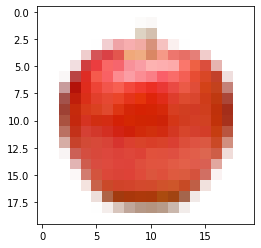


Prediction for the Image :  Pear Red


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
predict_random_image("apple.jpg", rfc)

Original Image


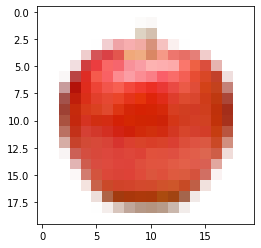


Prediction for the Image :  Pear Red


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
predict_random_image("apple.jpg", rfc3, doPCA=True)

Original Image


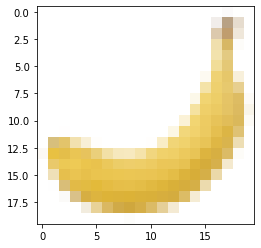


Prediction for the Image :  Cantaloupe 1


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
predict_random_image("banana.jpg", rfc)

Original Image


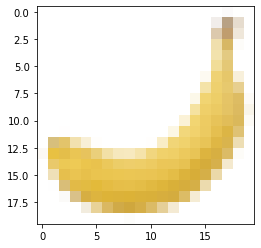


Prediction for the Image :  Banana Lady Finger


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
predict_random_image("banana.jpg", rfc3, doPCA=True)

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

#### Normalising Data

In [ ]:
X_norm = X/255.0
X_train_norm = X_train/255.0
X_val_norm = X_val/255.0

In [ ]:
test_X_norm = test_X/255.0

In [ ]:
X_norm = X_norm.reshape(-3, 20, 20, 3)
X_train_norm = X_train_norm.reshape(-3, 20, 20, 3)
X_val_norm = X_val_norm.reshape(-3, 20, 20, 3)

In [ ]:
test_X_norm = test_X_norm.reshape(-3, 20, 20, 3)

In [ ]:
X_norm.shape

(67692, 20, 20, 3)

#### Building the Model

In [ ]:
cnn_model = models.Sequential()

Feature Extraction Section (The Convolution and The Pooling Layer)

In [ ]:
# Feature Extraction Section (The Convolution and The Pooling Layer)
cnn_model.add(layers.Conv2D(filters=6, kernel_size=(2, 2), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
cnn_model.add(layers.AveragePooling2D())
cnn_model.add(layers.Conv2D(filters=16, kernel_size=(2, 2), activation='relu'))
cnn_model.add(layers.AveragePooling2D())

Reshape the image into one-dimensional vector

In [ ]:
# Reshape the image into one-dimensional vector
cnn_model.add(layers.Flatten())

Classification Section (The Fully Connected Layer)

In [ ]:
# Classification Section (The Fully Connected Layer)
cnn_model.add(layers.Dense(140, activation='relu'))
cnn_model.add(layers.Dense(150, activation='relu'))
cnn_model.add(layers.Dense(131, activation='softmax'))

In [ ]:
# Show summary of the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 6)         78        
                                                                 
 average_pooling2d (AverageP  (None, 9, 9, 6)          0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          400       
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 140)               3

Compiling the Model

In [ ]:
# Compile The Model
cnn_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

#### Testing the Model

Fit And Evaluate The Model Using Validation Dataset

In [ ]:
history = cnn_model.fit(X_norm, Y, epochs=10, validation_data=(X_val_norm, Y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2116/2116 [==============================] - 28s 13ms/step - loss: 0.9606 - accuracy: 0.7402 - val_loss: 0.2191 - val_accuracy: 0.9277
Epoch 2/10
2116/2116 [==============================] - 28s 13ms/step - loss: 0.1819 - accuracy: 0.9412 - val_loss: 0.0984 - val_accuracy: 0.9682
Epoch 3/10
2116/2116 [==============================] - 27s 13ms/step - loss: 0.1041 - accuracy: 0.9660 - val_loss: 0.0592 - val_accuracy: 0.9818
Epoch 4/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.0711 - accuracy: 0.9771 - val_loss: 0.0241 - val_accuracy: 0.9931
Epoch 5/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.0513 - accuracy: 0.9839 - val_loss: 0.0937 - val_accuracy: 0.9749
Epoch 6/10
2116/2116 [==============================] - 25s 12ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.0317 - val_accuracy: 0.9879
Epoch 7/10
2116/2116 [==============================] - 26s 12ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0052 - val_accura

#### Epoch vs Accuracy

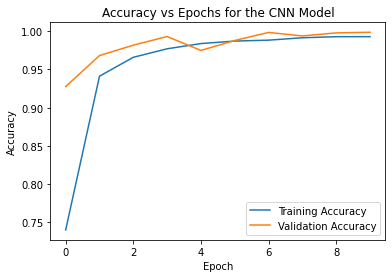

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title("Accuracy vs Epochs for the CNN Model")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.show()

#### Performance on Test Data

In [ ]:
y_pred_cnn = cnn_model.predict(test_X_norm).argmax(axis=1)

In [ ]:
y_pred_cnn

array([  8,   0,   0, ..., 130, 130, 130])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(test_Y, y_pred_cnn)

0.9419076163610719

In [ ]:
cnn_model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


In [ ]:
!zip -r /content/cnn_saved.zip /content/cnn_model

  adding: content/cnn_model/ (stored 0%)
  adding: content/cnn_model/saved_model.pb (deflated 89%)
  adding: content/cnn_model/assets/ (stored 0%)
  adding: content/cnn_model/keras_metadata.pb (deflated 91%)
  adding: content/cnn_model/variables/ (stored 0%)
  adding: content/cnn_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/cnn_model/variables/variables.index (deflated 66%)


In [ ]:
import tensorflow as tf

saved_dir = "cnn_model"

converter = tf.lite.TFLiteConverter.from_saved_model(saved_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
model_lite = converter.convert()


with open("cnn_model.tflite", 'wb') as f:
    f.write(model_lite)

#### Visualising random predictions

From testing data

Actual fruit : Onion White 
Predicted Fruit : Apple Pink Lady


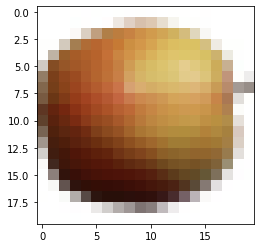

In [109]:
indx = np.random.randint(0, test_X.shape[0])
pred = y_pred_cnn[indx] 
actual = test_Y[indx]
img_dim = int((test_X.shape[1]/3)**0.5) 
image = test_X[indx].reshape(img_dim, img_dim,3)
print("Actual fruit : {} \nPredicted Fruit : {}".format(fruit_labels[pred], fruit_labels[actual]))
plt.imshow(image)
plt.show()

From Google Images

Original Image


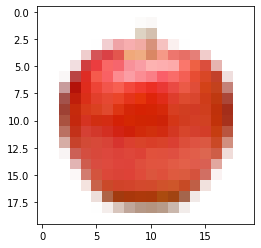


Prediction for the Image :  Pear Red


In [ ]:
predict_random_image("apple.jpg", cnn_model, isCNN=True)

Original Image


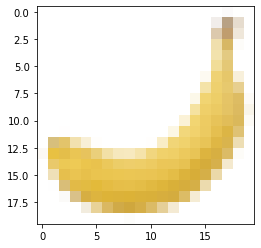


Prediction for the Image :  Banana Lady Finger


In [ ]:
predict_random_image("banana.jpg", cnn_model, isCNN=True)

In [ ]:
predict_random_image("eggplant.jpg", cnn_model, isCNN=True)

# Saving the trained final models using Pickle
(no need to run)

In [ ]:
import gc

gc.collect()

20807

In [ ]:
import bz2
import pickle
import _pickle as cPickle

In [ ]:
# Pickle a file and then compress it into a file with extension 
def save_compressed_pickle(filename, data):
 with bz2.BZ2File(filename + '.pbz2', 'w') as f:
   cPickle.dump(data, f)

In [ ]:
# Load any compressed pickle file
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data

In [ ]:
filename = 'lda_model'
save_compressed_pickle(filename, lda)

In [ ]:
filename = 'pca_model'
save_compressed_pickle(filename, pca)

In [ ]:
filename = 'knn_model_lda'
save_compressed_pickle(filename, knn)

In [ ]:
filename = 'rfc_model'
save_compressed_pickle(filename, rfc)

In [ ]:
filename = 'rfc_model_pca30'
save_compressed_pickle(filename, rfc3)

In [ ]:
filename = 'cnn_model'
save_compressed_pickle(filename, cnn_model)

INFO:tensorflow:Assets written to: ram://6427af38-ec0b-40c7-9336-91ecffcfa843/assets


INFO:tensorflow:Assets written to: ram://6427af38-ec0b-40c7-9336-91ecffcfa843/assets


In [ ]:
filename = 'fruit_labels'
save_compressed_pickle(filename, fruit_labels)

In [ ]:
! du -sh rfc_model_pca30.pbz2

11M	rfc_model_pca30.pbz2


# Pipeline

In [113]:
class Pipeline:
  '''Machine Learning Pipeline for Image Classfication on Fruits-360 dataset '''
  
  def __normalise_data(self, list_of_dataset_variables):
    '''Normalise each dataset provided in the list of datasets '''

    list_of_normalised_dataset_variables = []

    for x in list_of_dataset_variables:
      x_norm = x/255.0
      x_norm = x_norm.reshape(-3, 20, 20, 3)
      list_of_normalised_dataset_variables.append(x_norm)
    
    return list_of_normalised_dataset_variables

  def __build_cnn(self, x_train_norm, y_train, x_val_norm, y_val):
    '''Train a CNN on given data and return it'''

    cnn = models.Sequential()

    # Feature Extraction Section (The Convolution and The Pooling Layer)
    cnn.add(layers.Conv2D(filters=6, kernel_size=(2, 2), activation='relu', input_shape=(self.img_shape[0], self.img_shape[1], 3)))
    cnn.add(layers.AveragePooling2D())
    cnn.add(layers.Conv2D(filters=16, kernel_size=(2, 2), activation='relu'))
    cnn.add(layers.AveragePooling2D())

    # Reshape the image into one-dimensional vector
    cnn.add(layers.Flatten())

    # Classification Section (The Fully Connected Layer)
    cnn.add(layers.Dense(140, activation='relu'))
    cnn.add(layers.Dense(150, activation='relu'))
    cnn.add(layers.Dense(131, activation='softmax'))

    # Compile The Model
    cnn.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

    history = cnn.fit(x_train_norm, y_train, epochs=10, validation_data=(x_val_norm, y_val))
    return cnn

  def fit(self, train_data, image_dimensions):
    '''Preprocess given training data and Train a Classifier on it

    image_dimensions : Dimension of Images using which train_data was created 
    (for example if it was created using 20x20 RGB images, image_dimensions = (20, 20))'''

    self.img_shape = image_dimensions

    # Creating the test, train, validation datasets
    X = train_data.values[:, :-1]
    Y = train_data.values[:, -1]
      ## train, val split split
    X_train, X_val, Y_train, Y_val = tts(X, Y, test_size=0.3, random_state=20, stratify = Y)

    X_norm, X_train_norm, X_val_norm = self.__normalise_data([X, X_train, X_val])

    self.model = self.__build_cnn(X_norm, Y, X_val_norm, Y_val)

  def predict(self, test_data):
    '''Get the Predictions for given test data'''

    test_X = test_data.values[:, :-1]
    test_Y = test_data.values[:, -1]
    test_X_norm = self.__normalise_data(test_X)

    y_pred = self.model.predict(test_X_norm).argmax(axis=1)

    return y_pred

  def score(self, test_x, test_y):
    '''Get the accuracy score on given test data'''

    if(self.model == None):
      print("Error: Model not Trained and Tested yet")
    
    else:
      test_x_norm = self.__normalise_data(test_x)
      y_pred = self.model.predict(test_x_norm).argmax(axis=1)

      acc = accuracy_score(test_y, y_pred_cnn)
      print("Accuracy Score : {:.2f}%".format(acc*100))

      return acc

In [ ]:
pipeline = Pipeline()
pipeline.fit(train_data, (20, 20))

In [ ]:
y_pred_pipeline = pipeline.predict(test_data)

In [ ]:
pipeline.score(test_X, test_Y)